In [1]:
%load_ext autoreload
%autoreload 2

import gt4py as gt
from gt4py import gtscript
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from Test_Case_singleFunctions import *

mpl.rcParams["font.size"] = 16
backend = 'numpy'

/users/class160/HPC4WC_venv/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [ ]:
### staggering only ###

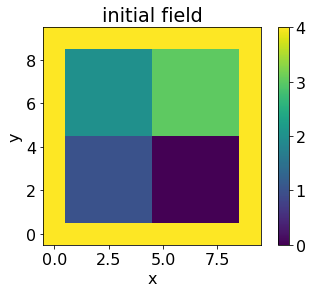

In [22]:
# grid size

nx = 10
ny = 10
nz=1

# storage shape

shape = (nx, ny, nz)
default_shape = (nx-2,ny-2,nz)
shape_staggered_x = (nx-1, ny, nz)
shape_staggered_y = (nx, ny-1, nz)

# default origin (trust it for now!)

default_origin = (1, 1, 0)
origin_staggered = (0,0,0)

# initial field

h_np = make_initial_field(shape, style='constants')
h = gt.storage.from_array(h_np, backend, default_origin)

In [16]:
# stencils

stencil_staggered_x = gtscript.stencil(definition=compute_staggered_x, backend=backend)
stencil_staggered_y = gtscript.stencil(definition=compute_staggered_y, backend=backend)

In [17]:
# output fields

hMidx = gt.storage.empty(backend, default_origin, shape_staggered_x, dtype=float)
hMidy = gt.storage.empty(backend, default_origin, shape_staggered_y, dtype=float)

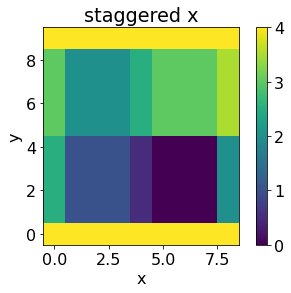

Output shape:  (9, 10, 1)


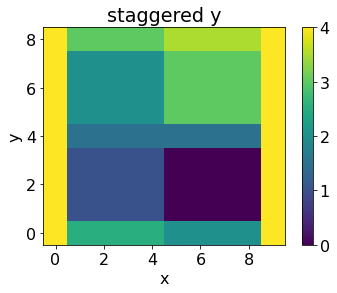

Output shape:  (10, 9, 1)


In [18]:
# compute stencils
args_x = [h, hMidx]
args_y = [h, hMidy]
evaluate_stencil(stencil_staggered_x, args_x, origin_staggered, shape_staggered_x, title='staggered x')
evaluate_stencil(stencil_staggered_y, args_y, origin_staggered, shape_staggered_y, title='staggered y')

In [ ]:
### staggering and computations for h ###

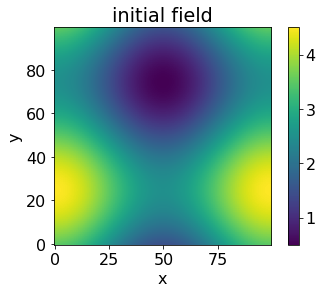

In [36]:
# grid size

nx = 100
ny = 100
nz=1

# storage shape

shape = (nx, ny, nz)
default_shape = (nx-2,ny-2,nz)
shape_staggered_x = (nx-1, ny, nz)
shape_staggered_y = (nx, ny-1, nz)
# shape_staggered_x = (nx-1, ny-2, nz) # ny-2
# shape_staggered_y = (nx-2, ny-1, nz) # nx-2

# default origin (trust it for now!)

default_origin = (1, 1, 0)
origin_staggered = (0,0,0) # leaving the halos
# origin_staggered_x = (0,1,0) # chopping off the y halo
# origin_staggered_y = (1,0,0)

# initial field

h_np = make_initial_field(shape, style='trigonometric')
h = gt.storage.from_array(h_np, backend, default_origin)

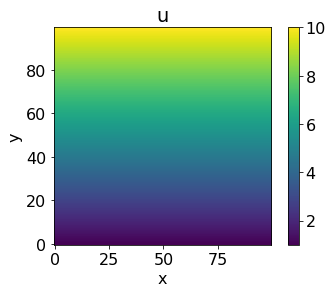

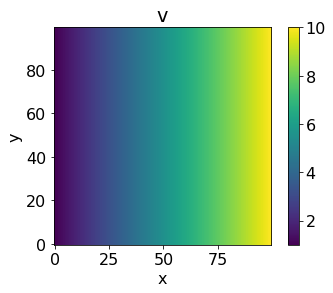

In [37]:
u_np = np.expand_dims(np.linspace(1,10,nx) * np.ones((nx,ny)), -1)
u = gt.storage.from_array(u_np, backend, default_origin)

plt.figure()
plt.imshow(u_np[:,:,0].T, origin='lower')
plt.title('u')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

v_np = np.linspace(1,10,ny)*np.ones((nx,ny))
v_np = np.expand_dims(v_np.T, -1)
v = gt.storage.from_array(v_np, backend, default_origin)

plt.figure()
plt.imshow(v_np[:,:,0].T, origin='lower')
plt.title('v')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

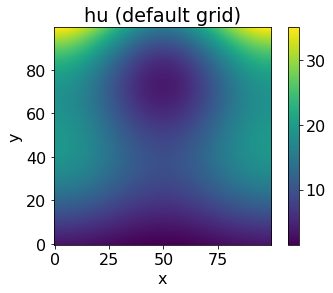

Output shape:  (100, 100, 1)


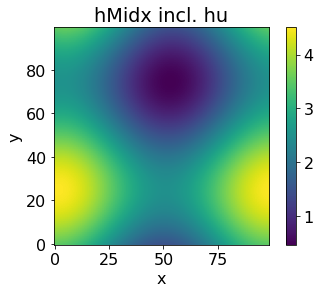

Output shape:  (99, 100, 1)


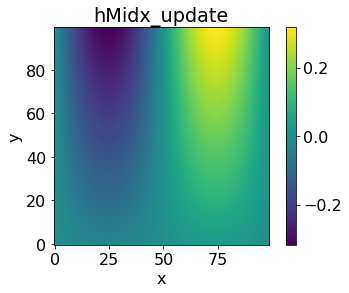

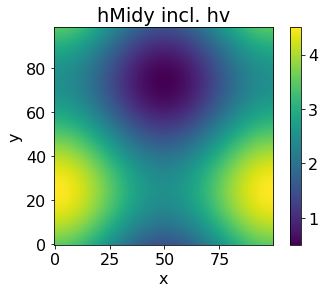

Output shape:  (100, 99, 1)


In [38]:
### test compute_hMidx including u an dhu

stencil_aux_variables = gtscript.stencil(definition=compute_aux_variables, backend=backend)
stencil_hMidx = gtscript.stencil(definition=compute_hMidx, backend=backend)
stencil_hMidy = gtscript.stencil(definition=compute_hMidy, backend=backend)


### computation on the FULL grid inluding halo: starting at 0,0,0 and domain_size = nx,ny,nz
hu = gt.storage.empty(backend, default_origin, shape, dtype=float)
hv = gt.storage.empty(backend, default_origin, shape, dtype=float)
args = [h, u, v, hv, hu]
evaluate_stencil(stencil_aux_variables, args, origin_staggered, shape, title='hu (default grid)')

### computation on x-staggered grid: starting at 0,0,0 and somain_size = nx-1,ny,nz
            # hMidx = 0.5 * (h[1:,1:-1] + h[:-1,1:-1]) - \
            #      0.5 * self.dt / self.dx[:,1:-1] * (hu[1:,1:-1] - hu[:-1,1:-1])


hMidx = gt.storage.empty(backend, origin_staggered, shape_staggered_x, dtype=float)
hMidx_update = gt.storage.empty(backend, origin_staggered, shape_staggered_x, dtype=float)
args = [h, hu, hMidx_update, hMidx]
evaluate_stencil(stencil_hMidx, args, origin_staggered, shape_staggered_x, title='hMidx incl. hu')

hMidx_update_np = np.asarray(hMidx_update)
plt.figure()
plt.imshow(hMidx_update_np[:,:,0].T, origin='lower')
plt.title('hMidx_update')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

hMidy = gt.storage.empty(backend, origin_staggered, shape_staggered_y, dtype=float)
args = [h, v, hMidy]
evaluate_stencil(stencil_hMidy, args, origin_staggered, shape_staggered_y, title='hMidy incl. hv')

In [ ]:
### FULL GRID        
            # hnew = h[1:-1,1:-1] - \
            #        self.dt / self.dxc * (huMidx[1:,:] - huMidx[:-1,:]) - \
            #        self.dt / self.dy1c * (hvMidy[:,1:]*self.cMidy[:,1:] - hvMidy[:,:-1]*self.cMidy[:,:-1])
stencil_update_h = gtscript.stencil(definition=update_h, backend=backend)

# missing: the above stuff should be without y halo.


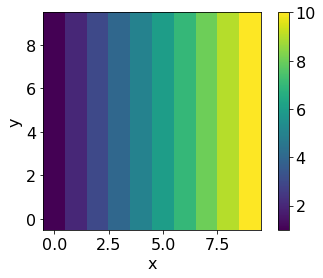

(10, 10, 1) (10, 8, 1)


ValueError: Compute domain too large (provided: (10, 8, 1), maximum: (10, 7, 1))

In [35]:
### test: chop off halo --- SHOULE BE DONE IN THE ABOVE!

def chop_halo_y(
    h: gtscript.Field[float],
    hc: gtscript.Field[float], ### check: full-field multiplication or only staggered domain?
    ):
    
    from __gtscript__ import PARALLEL, computation, interval
    with computation(PARALLEL), interval(...):
        hc = h[0,0,0]
stencil_chop_halo_y = gtscript.stencil(definition=chop_halo_y, backend=backend)

nx = ny = 10
h_np = np.expand_dims(np.linspace(1,10,nx) * np.ones((nx,ny)), -1)
plt.figure()
plt.imshow(h_np[:,:,0], origin='lower',vmin=1,vmax=10)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

h = gt.storage.from_array(h_np, backend, (1,1,0)) # full including halo in x and y
hc = gt.storage.empty(backend, (1,1,0), (nx,ny-2,nz), dtype=float) # halo only in x
print('goal shapes: ', h.shape, hc.shape)
evaluate_stencil(stencil_chop_halo_y, [h,hc], origin=(0,1,0), domain=(nx,ny-2,nz), title='chopped off the y halo',do_plot=False)


hc_np = np.asarray(hc)
plt.figure()
plt.imshow(hc_np[:,:,0], origin='lower',vmin=1,vmax=10)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [ ]:
''' COMPUTATION OF THE FORM: aMidx[1:,:] - aMidx[:-1,:]
--> two equally staggered variables, should work (moving_difference)

# Update fluid height
hnew = h[1:-1,1:-1] - \
       self.dt / self.dxc * (huMidx[1:,:] - huMidx[:-1,:]) - \
       self.dt / self.dy1c * (hvMidy[:,1:]*self.cMidy[:,1:] - hvMidy[:,:-1]*self.cMidy[:,:-1])
'''

In [ ]:
''' COMPUTATION OF THE FORM: aMidx[:-1,:] / bMidx[:-1,:]
--> two equally staggered variables, should work

hunew = hu[1:-1,1:-1] - \
        self.dt / self.dxc * (UxMid[1:,:] - UxMid[:-1,:]) - \
        self.dt / self.dy1c * (UyMid[:,1:] - UyMid[:,:-1]) + \
        self.dt * (self.f[1:-1,1:-1] + \
                    0.25 * (huMidx[:-1,:] / hMidx[:-1,:] + \
                            huMidx[1:,:] / hMidx[1:,:] + \
                            huMidy[:,:-1] / hMidy[:,:-1] + \
                            huMidy[:,1:] / hMidy[:,1:]) * \
                    self.tg / self.a) * \
        0.25 * (hvMidx[:-1,:] + hvMidx[1:,:] + hvMidy[:,:-1] + hvMidy[:,1:]) - \
        self.dt * self.g * \
        0.25 * (hMidx[:-1,:] + hMidx[1:,:] + hMidy[:,:-1] + hMidy[:,1:]) * \
        (self.hs[2:,1:-1] - self.hs[:-2,1:-1]) / (self.dx[:-1,1:-1] + self.dx[1:,1:-1])
'''

In [ ]:
''' COMPUTATION OF THE FORM: b = a if c>0 else d

# Update longitudinal moment
UxMid = np.where(hMidx > 0.0, \
                    huMidx * huMidx / hMidx + 0.5 * self.g * hMidx * hMidx, \
                    0.5 * self.g * hMidx * hMidx)
'''

In [ ]:
''' COMPUTATION OF THE FORM: a[:,1:-1] * (b[1:,1:-1] - b[:-1,1:-1])
where a.shape = (nx-1, ny), b.shape = (nx, ny)
[dx is x-staggered]

# # Mid-point value for h along x
hMidx = 0.5 * (h[1:,1:-1] + h[:-1,1:-1]) - \
     0.5 * self.dt / self.dx[:,1:-1] * (hu[1:,1:-1] - hu[:-1,1:-1])
'''